# [lingua-franca-translation](https://www.aicrowd.com/challenges/ai-blitz-xii/problems/lingua-franca-translation)

The pandemic may have paused your travel ventures, so we decided to give you a world tour through languages! Machine Translation or robot interpretation is an application of NLP, which simply translates text from one language to another without human contribution.

The Machine translation market is highly valued with tech firms wishing to make their content and services available to the masses. Startups like AppTek, Cloudworks, LingoTek, and many more utilize ML to the fullest to achieve smooth multi-lingual services.

Following the NLP theme of AI Blitz⚡XII, we present Language Translation, a challenge where AIcrowd presents its participants to try their hands at Machine Translation through our very own invented language “Crowd Talk”.

Coming with its own vocabulary and grammar, Crowd Talk, is sure to be a challenge waiting to be conquered or rather translated. Your model will be expected to perform straightforward replacement of words in the language by learning translation through NLP techniques.

In [ ]:
%%capture
!pip install tensorflow-addons
!pip install aicrowd-cli
%load_ext aicrowd.magic

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/0J0AL69JfIr75_gehWfOPpYJELACHNocBqppvF5hBSQ
API Key valid
Saved API Key successfully!


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c lingua-franca-translation -o data

sample_submission.csv:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/437k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/1.92M [00:00<?, ?B/s]

# Librerias

In [ ]:
import os, pathlib, sys, io, collections, logging
import re, string, unicodedata
import time
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow_addons.optimizers import *

from sklearn.model_selection import train_test_split

# Data e Preprocessing

In [ ]:
train = pd.read_csv('data/train.csv', encoding='utf8')
test = pd.read_csv('data/test.csv', encoding='utf8')
sub = pd.read_csv('data/sample_submission.csv', encoding='utf8')
train.head(5)

,id,crowdtalk,english
0,31989,wraov driourth wreury hyuirf schneiald chix lo...,upon this ladder one of them mounted
1,29884,treuns schleangly kriaors draotz pfiews schlio...,and solicited at the court of Augustus to be p...
2,26126,toirts choolt chiugy knusm squiend sriohl gheold,but how am I sunk!
3,44183,schlioncy yoik yahoos dynuewn maery schlioncy ...,the Yahoos draw home the sheaves in carriages
4,19108,treuns schleangly tsiens mcgaantz schmeecks tr...,and placed his hated hands before my eyes


In [ ]:
def preprocess_sentence(w):
  w = w.lower().strip()

  # crea spazi intorno ai caratteri ?.!,'
  # https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  # w = re.sub(r"([?.!,'])", r" \1 ", w)
  w = re.sub(r"([?.!,'])", r" ", w)
  w = re.sub(r'[" "]+', " ", w)

  # rimpiazza tutto con spazi eccetto (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,']+", " ", w)
  # rimuove gli spazi multipli
  w = re.sub(" +", " ", w)
  w = w.strip()

  # aggiunge i token start e end così che il modello capisca quando iniziare e finire a predirre
  w = '<start> ' + w + ' <end>'
  return w

def create_dataset(data):
  crowdtalk = data['crowdtalk'].apply(preprocess_sentence)
  english = data['english'].apply(preprocess_sentence)
  return crowdtalk, english

def tokenize(lang, len=None):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=len)
  return tensor, lang_tokenizer

def load_dataset(data):
  inp_lang, targ_lang = create_dataset(data)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang, input_tensor.shape[1] + 1)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(train)
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

# calcolo la lunghezza massima degli input
max_length_inp, max_length_targ = input_tensor.shape[1], target_tensor.shape[1]
print("Max len input: {}, Max len target: {}".format(max_length_inp, max_length_targ))

Max len input: 41, Max len target: 42


# Split e data generation

In [ ]:
# training e validation con split
input_train, input_val, target_train, target_val = train_test_split(input_tensor, target_tensor, test_size=0.025, random_state=0)
print(len(input_train), len(target_train), len(input_val), len(target_val))

11656 11656 299 299


In [ ]:
def format_dataset(inp_lang, targ_lang):
    return ({"encoder_inputs": inp_lang, "decoder_inputs": targ_lang[:, :-1],}, targ_lang[:, 1:])

def make_dataset(input, target):
  inp_lang = input.tolist()
  targ_lang = target.tolist()
  dataset = tf.data.Dataset.from_tensor_slices((inp_lang, targ_lang))
  dataset = dataset.batch(batch_size)
  dataset = dataset.map(format_dataset)
  return dataset.shuffle(2048).prefetch(16).cache()

batch_size = 64
train_ds = make_dataset(input_train, target_train)
val_ds = make_dataset(input_val, target_val)

for inputs, targets in train_ds.take(1):
  print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
  print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
  print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 41)
inputs["decoder_inputs"].shape: (64, 41)
targets.shape: (64, 41)


# Seq2Seq Transformer

The model is based on the [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) publication. In this notebook, a seq2seq Transformer model is created which has 2 encoders and 2 decoders: the decoder models are used to generate a representation of the input language, while the encoders are used to predict the target language.

In [ ]:
class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim, rate=0.1, **kwargs):
    super(PositionalEmbedding, self).__init__(**kwargs)
    self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)
    self.spatial_dropout = layers.SpatialDropout1D(rate)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim

  def call(self, inputs, training):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_tokens = self.spatial_dropout(embedded_tokens, training=training)
    embedded_positions = self.position_embeddings(positions)
    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, rate=0.1, **kwargs):
    super(TransformerEncoder, self).__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),])
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.supports_masking = True

  def call(self, inputs, training, mask=None):
  # def call(self, inputs, mask=None):
    if mask is not None:
      padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")
    attention_output = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=padding_mask)
    attention_output = self.dropout1(attention_output, training=training)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    proj_output = self.dropout2(proj_output, training=training)
    return self.layernorm_2(proj_input + proj_output)

class TransformerDecoder(layers.Layer):
  def __init__(self, embed_dim, latent_dim, num_heads, rate=0.1, **kwargs):
    super(TransformerDecoder, self).__init__(**kwargs)
    self.embed_dim = embed_dim
    self.latent_dim = latent_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.dense_proj = keras.Sequential([layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),])
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    self.dropout1 = layers.Dropout(rate)
    self.dropout2 = layers.Dropout(rate)
    self.dropout3 = layers.Dropout(rate)
    self.supports_masking = True

  # def call(self, inputs, encoder_outputs, mask=None):
  def call(self, inputs, encoder_outputs, training, mask=None):
    causal_mask = self.get_causal_attention_mask(inputs)
    if mask is not None:
      padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
      padding_mask = tf.minimum(padding_mask, causal_mask)

    attention_output_1 = self.attention_1(query=inputs, value=inputs, key=inputs, attention_mask=causal_mask)
    attention_output_1 = self.dropout1(attention_output_1, training=training)
    out_1 = self.layernorm_1(inputs + attention_output_1)
    attention_output_2 = self.attention_2(query=out_1, value=encoder_outputs, key=encoder_outputs, attention_mask=padding_mask,)
    attention_output_2 = self.dropout2(attention_output_2, training=training)
    out_2 = self.layernorm_2(out_1 + attention_output_2)

    proj_output = self.dense_proj(out_2)
    proj_output = self.dropout3(proj_output, training=training)
    return self.layernorm_3(out_2 + proj_output)

  def get_causal_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i >= j, dtype="int32")
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], axis=0,)
    return tf.tile(mask, mult)

## Parameters

In [ ]:
epochs = 50
embed_dim = 256
latent_dim = 512
num_heads = 4
dr_transformer = 0.1
dr = 0.5
dr_spatial = 0.2

## Optimizer scheduler / loss

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  return tf.reduce_mean(loss_)

183


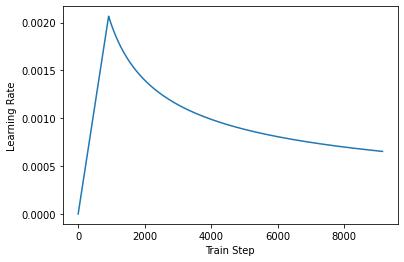

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

steps_epoch = (len(input_train) // batch_size) + 1
print(steps_epoch)
learning_rate = CustomSchedule(embed_dim, warmup_steps=steps_epoch * (epochs // 10))

temp_learning_rate_schedule = CustomSchedule(embed_dim, warmup_steps=steps_epoch * (epochs // 10))
plt.plot(temp_learning_rate_schedule(tf.range(steps_epoch * epochs, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

## Model

In [ ]:
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(max_length_inp, vocab_inp_size, embed_dim, rate=dr_spatial)(encoder_inputs)

encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads, rate=dr_transformer)(x)
encoder_outputs_2 = TransformerEncoder(embed_dim, latent_dim, num_heads, rate=dr_transformer)(encoder_outputs)
encoder = keras.Model(encoder_inputs, encoder_outputs_2)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
encoded_seq_inputs_2 = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs_2")

x = PositionalEmbedding(max_length_targ, vocab_tar_size, embed_dim, rate=dr_spatial)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads, rate=dr_transformer)(x, encoded_seq_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads, rate=dr_transformer)(x, encoded_seq_inputs_2)
x = layers.Dropout(dr)(x)
decoder_outputs = layers.Dense(vocab_tar_size, activation='softmax')(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs, encoded_seq_inputs_2], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs, encoder_outputs_2])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

checkpoint_filepath = 'model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', save_best_only=True, verbose=True)

transformer.summary()
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    loss=loss_function,
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
)
transformer.fit(
    train_ds, 
    epochs=epochs, 
    validation_data=val_ds, 
    callbacks=[model_checkpoint_callback]
    )

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding_12 (Posit  (None, None, 256)   2378240     ['encoder_inputs[0][0]']         
 ionalEmbedding)                                                                                  
                                                                                                  
 transformer_encoder_12 (Transf  (None, None, 256)   1315840     ['positional_embedding_12[0][0]']
 ormerEncoder)                                                                                    
                                                                                        

In [ ]:
transformer.load_weights(checkpoint_filepath)

## Prediction examples

In [ ]:
%%time
def preprocess_sentence_test(text_input):
  text_input = preprocess_sentence(text_input)
  text_input = inp_lang.texts_to_sequences([text_input])
  return tf.keras.preprocessing.sequence.pad_sequences(text_input, maxlen=max_length_inp, padding='post')
  
def decode_sequence(text_input, set='train'):
  if set == 'train':
    text_input = preprocess_sentence_test(text_input)

  decoded_sentence = "<start>"
  tokenized_target_sentence = np.zeros(shape=(1, max_length_inp), dtype='int')
  tokenized_target_sentence[0, 0] = targ_lang.texts_to_sequences([decoded_sentence])[0][0]

  for i in range(max_length_inp):

    predictions = transformer([text_input, tokenized_target_sentence])
    sampled_token_index = np.argmax(predictions[0, i, :])
    sampled_token = targ_lang.index_word[sampled_token_index]
    decoded_sentence += " " + sampled_token

    if i != (max_length_inp - 1):
      tokenized_target_sentence[0, i+1] = sampled_token_index

    if sampled_token == "<end>":
      break
  
  out = re.sub('<start> ', '', decoded_sentence)
  out = re.sub(' <end>', '', out)
  return out

for i in range(20):
  test_eng_texts = train.crowdtalk[i]
  print()
  print('real:', train.english[i])
  print('pred:', decode_sequence(test_eng_texts))


real: upon this ladder one of them mounted
pred: upon this ladder one of them mounted

real: and solicited at the court of Augustus to be preferred to a greater ship
pred: and solicited at the court of augustus to be fitness to a greater ship

real: but how am I sunk!
pred: but how am i sunk

real: the Yahoos draw home the sheaves in carriages
pred: the yahoos draw home the wholesomer in carriages

real: and placed his hated hands before my eyes
pred: and placed his hated hands before my eyes

real: that was of smooth stone.
pred: that was of smooth stone

real: as I gathered from some general words I overheard among them
pred: as i gathered from some general words i overheard among them

real: but do not interfere with my motions
pred: but do not interfere with my motions

real: If their prey held out
pred: if their prey held out

real: I avoided explanation and maintained a continual silence concerning the wretch I had created.
pred: i avoided explanation and maintained a continual 

# Prediction e sumbission

In [ ]:
def preprocess_sentence_test(text_input):
  text_input = [preprocess_sentence(i) for i in text_input]
  text_input = inp_lang.texts_to_sequences(text_input)
  return tf.keras.preprocessing.sequence.pad_sequences(text_input, maxlen=max_length_inp, padding='post')
  
def decode_sequence(text_input):
  text_input = preprocess_sentence_test(text_input)
  tokenized_target_sentence = np.zeros(shape=(text_input.shape[0], max_length_inp), dtype='int')
  tokenized_target_sentence[:, 0] = targ_lang.texts_to_sequences(["<start>"])[0][0]

  for i in range(max_length_inp):
    predictions = transformer([text_input, tokenized_target_sentence])
    sampled_token_index = np.argmax(predictions[:, i, :], -1)
    if i != (max_length_inp - 1):
      tokenized_target_sentence[:, i + 1] = sampled_token_index
  return targ_lang.sequences_to_texts(tokenized_target_sentence)

In [ ]:
%%time
def get_every_n(a, n=2):
  for i in range((a.shape[0] // n) + 1):
    yield a[n*i:n*(i+1)]

preds = []
for n, sa in enumerate(get_every_n(test['crowdtalk'].values, n=256)):
  preds.extend(decode_sequence(sa))

CPU times: user 1min 29s, sys: 3.02 s, total: 1min 32s
Wall time: 2min 27s


In [ ]:
preds_post_processing = []
for i in preds:
  i = i.split('<start> ')[1]
  i = i.split(' <end>')[0]
  i = i.strip()
  # i = re.sub(r"\s([?.!,'])", r"\1", i)
  i = re.sub(r"([?.!,'])", r"", i)
  i = re.sub(r" +", " ", i)
  i = i.strip()
  if i == '':
    i = '<unk>'
    print('unk inserted')
  preds_post_processing.append(i)

In [ ]:
sub = test.copy()
sub['prediction'] = preds_post_processing
!rm -rf assets
!mkdir assets
sub.to_csv(os.path.join("assets", "submission.csv"), index=False)
sub

,id,crowdtalk,prediction
0,27226,treuns schleangly throuys praests qeipp cyclui...,and reported strange things of my beauty
1,31034,feosch treuns schleangly gliath spluiey gheuck...,scared and crimes as i was
2,35270,scraocs knaedly squiend sriohl clield whaioght...,when i found myself on my feet
3,23380,sqaups schlioncy yoik gnoirk cziourk schnaunk ...,according to the license he had given me
4,92117,schlioncy yoik psycheiancy mcountz pously mcna...,the very worst effects that avarice
...,...,...,...
3980,22854,scraocs knaedly daioc mceab spriaonn schmeips ...,when it did not rain
3981,24201,toirts choolt blointly spriaonn schmeips krous...,but she did not answer
3982,33494,scraocs knaedly daioc mceab sooc kniousts clie...,when it was found i could neither understand n...
3983,28988,czogy stoorty wheians veurg mcmoorth dwiountz ...,by which they distinguish themselves


In [ ]:
%aicrowd notebook submit -c lingua-franca-translation -a assets --no-verify

Using notebook: [Transformer] Lingua Franca Translation.ipynb for submission...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                       
                                                       │ Successfully submitted! │                                                       
                                                       ╰─────────────────────────╯

                                                             Important links                                                             
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/lingua-franca-translation/submissions/171818              │
│                  │                                                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/lingua-franca-translation/submissions?my_submissions=true │
│                  │                                                                                                                    │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/lingua-franca-translation/leaderboards                    │
│                  │                                                                                                                    │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xii                                                                       │
│                  │                                                                                                                    │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xii/problems/lingua-franca-translation                                 │
└──────────────────┴────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

# References

Loss and Schedule: https://www.tensorflow.org/text/tutorials/transformer

Transformer code: https://keras.io/examples/nlp/neural_machine_translation_with_transformer/

Text preprocessing: https://www.tensorflow.org/text/tutorials/nmt_with_attention